#### 1. Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
We have for example `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver` are available. 

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

We use `PySCFDriver` here.

In [1]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'

driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

After execute driver we can look into the attributes of `qmolecule`.

In [2]:
# the total number of electrons in system
n_el = qmolecule.num_alpha + qmolecule.num_beta

# the number of molecular orbitals
n_mo = qmolecule.num_molecular_orbitals

# the number of spin-orbitals
n_so = 2 * qmolecule.num_molecular_orbitals

# the number of qubits need to simulate this molecule with Jordan-Wigner mapping
n_q = 2* qmolecule.num_molecular_orbitals
print("The number of qubits need to simulate this molecule: %i" % n_q)

# the value of the nuclear repulsion energy
e_nn = qmolecule.nuclear_repulsion_energy

The number of qubits need to simulate this molecule: 12


#### 2. Electronic structure problem

Now, we can create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).

Our main goal is reduce the number of qubits required to encode the problem.
We can achieve this using `FreezeCoreTransformer` (https://qiskit.org/documentation/nature/stubs/qiskit_nature.transformers.FreezeCoreTransformer.html). It allow us to made inactive and remove the core_orbitals listed in the QMolecule. Additionally we can remove molecular orbitals unoccupied or with low contribution to whole energy.


In [3]:
from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem


# This is important step, it reduce the number of qubits from 12 to 6.
freezeCoreTransfomer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3, 4])

# Please, note usage of the freezeCoreTransfomer during encode problem.
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#### 3. QubitConverter

Allows to define the mapping that you will use in the simulation. I use `ParityMapper`
because it allows us to reduce two more qubits.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper = ParityMapper()

converter = QubitConverter(mapper=mapper,
                           two_qubit_reduction=True
                           # We can also use symmetry reduction, but it is not necessary
                           # , z2symmetry_reduction=[1, 1]
                          )

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

#### 4. Initial state
As we described in the Theory section, a good initial state in chemistry is the HF state.

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


#### 5. Ansatz
One of the most important choices is the quantum circuit that you choose to approximate your ground state.

I use the ansatz with linear entanglement (so we use only 3 cnot gates), this is my custom ansatz but it is similar to SU2 from qiskit.circuit.library.EfficientSU2. 

In [6]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister

def create_ansatz(begin_gates, end_gates):
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)

    # init gates
    for gate in begin_gates:
        for i in range(n):
            if gate == "y":
                qc.ry(Parameter("lv0_ry_%i" % i), i)
            elif gate == "z":
                qc.rz(Parameter("lv0_rz_%i" % i), i)
            else:
                qc.rx(Parameter("lv0_rx_%i" % i), i)
    qc.barrier()


    # Place a CNOT ladder
    for i in range(n - 1):
        qc.cx(i, i + 1)
        qc.ry(Parameter("spc_ry_%i" % (i + 1)), i + 1)
        qc.rz(Parameter("spc_rz_%i" % (i+1)), i + 1)
    # Visual separator
    qc.barrier()

    # ends qubits
    for gate in end_gates:
        for i in range(n):
            if gate == "y":
                qc.ry(Parameter("lv1_ry_%i" % i), i)
            elif gate == "z":
                qc.rz(Parameter("lv1_rz_%i" % i), i)
            else:
                qc.rx(Parameter("lv1_rx_%i" % i), i)
        
    ansatz = qc
    return ansatz

In [7]:
ansatz = create_ansatz(['z', 'y', 'x'], [])
ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

          ┌───┐      ┌──────────────┐┌──────────────┐┌──────────────┐ ░      »
q_0: ─────┤ X ├──────┤ RZ(lv0_rz_0) ├┤ RY(lv0_ry_0) ├┤ RX(lv0_rx_0) ├─░───■──»
          ├───┤      ├──────────────┤├──────────────┤├──────────────┤ ░ ┌─┴─┐»
q_1: ─────┤ X ├──────┤ RZ(lv0_rz_1) ├┤ RY(lv0_ry_1) ├┤ RX(lv0_rx_1) ├─░─┤ X ├»
     ┌────┴───┴─────┐├──────────────┤├──────────────┤└──────────────┘ ░ └───┘»
q_2: ┤ RZ(lv0_rz_2) ├┤ RY(lv0_ry_2) ├┤ RX(lv0_rx_2) ├─────────────────░──────»
     ├──────────────┤├──────────────┤├──────────────┤                 ░      »
q_3: ┤ RZ(lv0_rz_3) ├┤ RY(lv0_ry_3) ├┤ RX(lv0_rx_3) ├─────────────────░──────»
     └──────────────┘└──────────────┘└──────────────┘                 ░      »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«     ┌──────────────┐┌──────────────┐                                     »
«q_1: ┤ RY(spc_ry_1) ├┤ RZ(spc_rz_1) ├──■─────────────────

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.

In [8]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.

I use `SLSQP` optimizer.

In [9]:
from qiskit.algorithms.optimizers import SLSQP

optimizer = SLSQP(maxiter=5000)

#### 8. Exact eigensolver

In [10]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)


Exact electronic energy -1.0887060157347408
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [11]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1029,
    'eigenstate': array([ 2.74931657e-03+1.94109304e-04j, -2.52579776e-07-5.49359999e-07j,
       -2.35323221e-02+2.04982869e-03j,  9.91515186e-01-2.88068869e-02j,
        4.96268800e-02-7.92643415e-04j, -5.38573572e-06-9.46322295e-06j,
       -2.30394172e-05+1.57135822e-06j,  9.69689724e-04-9.94468806e-06j,
       -2.07631018e-08+2.43777146e-07j,  4.90853419e-11-2.17125527e-11j,
       -1.51690839e-07-2.09134102e-06j,  1.28231378e-06+8.80429544e-05j,
       -1.14107160e-01+3.52195527e-03j,  1.27103523e-05+2.15795946e-05j,
        5.29333686e-05-4.40264901e-06j, -2.22979882e-03+5.60689811e-05j]),
    'eigenvalue': -1.0862545676536888,
    'optimal_parameters': {   Parameter(lv0_rz_3): 0.009999203640766901,
                              Parameter(lv0_ry_0): 0.253718127739101,
                              Parameter(lv0_ry_1): -0.18749529896669562,
                              Parameter(lv0_ry_2): -0.0245767806494088

#### 9. Scoring function 

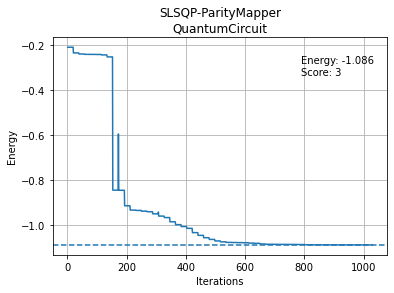

In [12]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': None,
    'entanglement_blocks': None,
    'entanglement': None,
    'repetitions': None,
    'skip_final_rotation_layer': None,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

In [13]:
print('Pass:', result_dict['pass'])
print('Score:', result_dict['score'])
print('Error:', result_dict['error (mHa)'], 'mHa')
print('Number of parameters:', result_dict['# of parameters'])

Pass: True
Score: 3
Error: 2.451448081052021 mHa
Number of parameters: 18
